In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

In [82]:
from scipy.stats import median_abs_deviation as mad

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
plt.style.use('seaborn-notebook')
plt.style.use('ggplot')

In [4]:
import pymc3 as pm

# 9.3 Uncertainty in the predicted expectation and the forecast

In [5]:
data = pd.read_csv('../ROS-Examples/ElectionsEconomy/data/hibbs.dat', sep=' ')

In [6]:
data.head()

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon


In [57]:
res = smf.glm('vote~growth', data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   vote   No. Observations:                   16
Model:                            GLM   Df Residuals:                       14
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          14.162
Method:                          IRLS   Log-Likelihood:                -42.839
Date:                Sun, 30 May 2021   Deviance:                       198.27
Time:                        13:12:28   Pearson chi2:                     198.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.2476      1.622     28.514      0.000      43.069      49.427
growth         3.0605      0.696      4.396      0.000       1.696       4.425
==============================================================================
"""

In [39]:
with pm.Model() as model:
    pm.glm.linear.GLM.from_formula('vote~growth', data)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sd, growth, Intercept]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 8 seconds.


/home/jfyu/miniconda3/envs/ros/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f080a071490>,
      dtype=object)

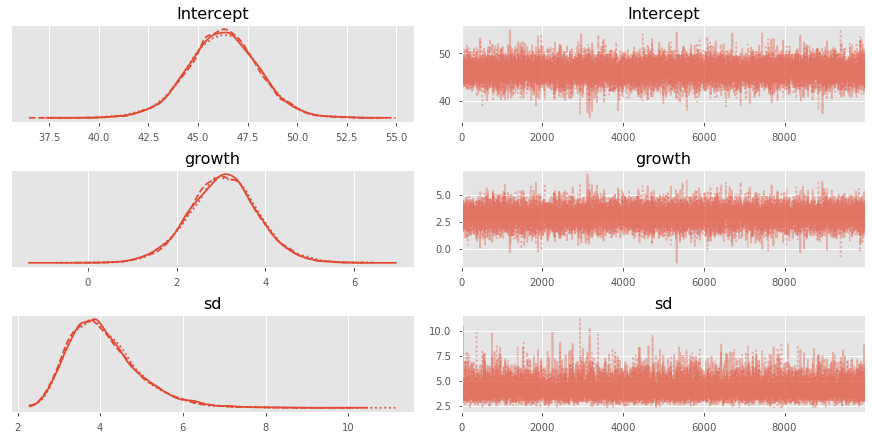

In [40]:
pm.traceplot(trace)

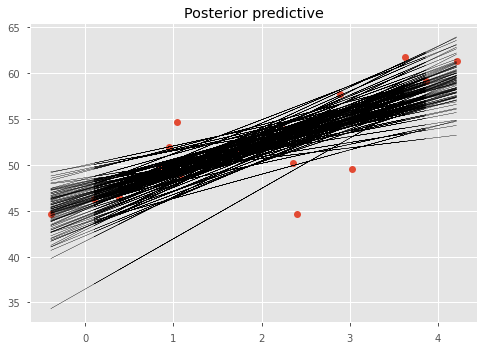

In [42]:
plt.plot(data['growth'], data['vote'], 'o',label="data")
pm.plot_posterior_predictive_glm(trace, samples=100, 
                                 lm = lambda x, sample: sample["Intercept"] + sample["growth"] * x, 
                                 label="posterior predictive regression lines",
                                eval = data['growth'])

In [71]:
a_hat = np.mean(trace['Intercept'])
b_hat = np.mean(trace['growth'])
sigma_hat = np.mean(trace['sd'])

In [72]:
a_hat

46.24827909265164

In [73]:
b_hat

3.055998834364025

In [74]:
sigma_hat

4.094912370980202

Point estimate

In [65]:
x_new = 2

In [66]:
a_hat+b_hat*x_new

52.364641870946656

In [78]:
sigma_linpred = sigma_hat*np.sqrt(1/len(data['vote'])+
                                 np.power(x_new-np.mean(data['growth']),2)
                                 /np.sum(np.power(data['growth']-np.mean(data['growth']), 2)))

In [68]:
sigma_linpred

0.9924373967171424

In [69]:
sigma_prediction = sigma_hat*np.sqrt(1+1/len(data['vote'])+
                                 np.power(x_new-np.mean(data['growth']),2)
                                 /np.sum(np.power(data['growth']-np.mean(data['growth']), 2)))

In [70]:
sigma_prediction

4.080892178698337

Doing `linpred` by hand using `pymc3`

In [75]:
y_linpred = trace['Intercept']+trace['growth']*x_new

In [76]:
y_linpred.mean()

52.3602767613797

In [77]:
y_linpred.std()

1.0501921152863063

In [84]:
mad(y_linpred, scale='normal')

0.9858752625408395

this is close to the sigma calculated

Doing `psosterior_predict`

In [85]:
len(trace)

10000

In [87]:
y_pred = trace['Intercept']+trace['growth']*x_new + np.random.normal(0, trace['sd'])

In [88]:
mad(y_pred, scale='normal')

4.102878008689911

In [89]:
y_pred.mean()

52.37936963931058

# 9.4 Partial Pooling

Need to solve Eq. 9.3 given everything but $se_{data}$

In [98]:
0.07/np.power(0.05,3)*0.54*(1-0.54)

139.10399999999998

n = 139

In [115]:
# sd for the posterior is in Eq. 9.4

sd_posterior = 1/np.sqrt((1/np.power(0.05,2)+1/(0.54*(1-0.54)/139)))

In [116]:
sd_posterior

0.03228190145063747

In [117]:
# if the candidate wins election, then they would have share of vote > 0.5

1-stats.norm.cdf(0.5, loc=0.54, scale = sd_posterior)

0.8923428754058724

# 9.5 Combining prior information and data

In [118]:
def bayes_sd(se_prior, se_data):
    return 1/(np.sqrt(1/np.power(se_prior,2)+1/np.power(se_data,2)))

In [124]:
def bayes_mean(theta_prior, theta_data, se_prior, se_data):
    return (theta_prior/np.power(se_prior,2)+theta_data/np.power(se_data,2))*np.power(bayes_sd(se_prior,se_data),2)

In [125]:
def se_data(p,n):
    return np.sqrt(p*(1-p)/n)

Just checking

In [126]:
se_data(0.54, 139)

0.042273518421255527

In [127]:
bayes_sd(0.05, se_data(0.54, 139))

0.03228190145063747

In [128]:
bayes_mean(0.42, 0.54, 0.05, se_data(0.54, 139))

0.48997818425910394

Ok let's do the work

In [129]:
bayes_mean(-0.02, 0.16, 0.05, 0.08)

0.03056179775280899

In [130]:
bayes_sd(0.05, 0.08)

0.0423999152002544

# 9.6 Bayesian inference with a zero-centered informative prior on the log scale

it's actually Exercise 4.8 they are referring to

In [158]:
b_mean = bayes_mean(0, 0.35, 0.1, 0.17)
b_mean

0.08997429305912598

In [165]:
b_sd = bayes_sd(0.1, 0.17)
b_sd

0.08619342151577697

In [166]:
np.exp(b_mean)

1.094146156193131

In [167]:
np.exp(b_mean+2*b_sd) #one end point of the 95 CL

1.299995933116507

In [168]:
np.exp(b_mean-2*b_sd) #one end point of the 95 CL

0.9208919663634926